# Demo: sequences <-> embeddings
The following notebook provides a demonstration how the ts2e library can be used to convert time series into embeddings. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN). All the column descriptions are provided. Currency is USD.

In [71]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [72]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import seaborn as sns
import networkx as nx
import pandas as pd
from to_graph.strategies import TimeseriesToGraphStrategy, TimeseriesEdgeVisibilityConstraintsNatural, EdgeWeightingStrategyNull
from embeddings.vectors import TimeSeriesEmbedding
from sklearn.preprocessing import MinMaxScaler
from core import model 

## Loading data

We first load the dataset :)

In [73]:
amazon_data = pd.read_csv(os.path.join(os.getcwd(), "amazon", "AMZN.csv"))

To properly use the ‘Date’ column, we convert it to datetime format and ensure the dates are recognized as date objects. We then set the ‘Date’ column as the index of the DataFrame. This creates a time-series structure, facilitating analysis and visualization over time.

In [74]:
amazon_data["Date"] = pd.to_datetime(amazon_data["Date"])
amazon_data.set_index("Date", inplace=True)

# How does the time series look like?

In [75]:
def plot_timeseries(sequence, title, x_legend, y_legend, color):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

In [76]:
def plot_timeseries_sequence(df_column, title, x_legend, y_legend, color='black'):
    sequence = model.Timeseries(model.TimeseriesArrayStream(df_column)).to_sequence()
    plot_timeseries(sequence, title, x_legend, y_legend, color)

In [77]:
def sequence_to_graph(column, color):
    strategy = TimeseriesToGraphStrategy(
        visibility_constraints=[TimeseriesEdgeVisibilityConstraintsNatural()],
        graph_type="undirected",
        edge_weighting_strategy=EdgeWeightingStrategyNull(),
    )

    g = strategy.to_graph(model.TimeseriesArrayStream(column))
    pos=nx.spring_layout(g.graph, seed=1)
    nx.draw(g.graph, pos, node_size=40, node_color=color)

In [78]:
"""plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")"""

'plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")'

Given the great length of the timeseries, let's focus on some sub-segments, so that we can better appreciate its behavior.

In [79]:
segment_1 = amazon_data[60:260]
segment_2 = amazon_data[960:1160]
segment_3 = amazon_data[3120:3320]
segment_4 = amazon_data[4320:4520]
segment_5 = amazon_data[5640:5840]
segment_6 = amazon_data[6000:6200]

How do the plots and networks (graphs) for these segments look like?

In [80]:
"""plot_timeseries_sequence(segment_1["Close"], "Example 1: Segment 1 for Amazon data", "Year", "Value", 'gray')
sequence_to_graph(segment_1["Close"], 'gray')"""

'plot_timeseries_sequence(segment_1["Close"], "Example 1: Segment 1 for Amazon data", "Year", "Value", \'gray\')\nsequence_to_graph(segment_1["Close"], \'gray\')'

In [81]:
"""plot_timeseries_sequence(segment_2["Close"], "Example 2: Segment 2 from Amazon data", "Year", "Value", 'green')
sequence_to_graph(segment_2["Close"], 'green')"""

'plot_timeseries_sequence(segment_2["Close"], "Example 2: Segment 2 from Amazon data", "Year", "Value", \'green\')\nsequence_to_graph(segment_2["Close"], \'green\')'

In [82]:
"""plot_timeseries_sequence(segment_3["Close"], "Example 3: Segment 3 from Amazon data", "Year", "Value", 'blue')
sequence_to_graph(segment_3["Close"], 'blue')"""

'plot_timeseries_sequence(segment_3["Close"], "Example 3: Segment 3 from Amazon data", "Year", "Value", \'blue\')\nsequence_to_graph(segment_3["Close"], \'blue\')'

In [83]:
"""plot_timeseries_sequence(segment_4["Close"], "Example 4: Segment 4 from Amazon data", "Year", "Value", 'red')
sequence_to_graph(segment_4["Close"], 'red')"""

'plot_timeseries_sequence(segment_4["Close"], "Example 4: Segment 4 from Amazon data", "Year", "Value", \'red\')\nsequence_to_graph(segment_4["Close"], \'red\')'

In [84]:
"""plot_timeseries_sequence(segment_5["Close"], "Example 5: Segment 5 from Amazon data", "Year", "Value", 'orange')
sequence_to_graph(segment_5["Close"], 'orange')"""

'plot_timeseries_sequence(segment_5["Close"], "Example 5: Segment 5 from Amazon data", "Year", "Value", \'orange\')\nsequence_to_graph(segment_5["Close"], \'orange\')'

In [85]:
"""plot_timeseries_sequence(segment_6["Close"], "Example 6: Segment 6 from Amazon data", "Year", "Value", 'yellow')
sequence_to_graph(segment_6["Close"], 'yellow')"""

'plot_timeseries_sequence(segment_6["Close"], "Example 6: Segment 6 from Amazon data", "Year", "Value", \'yellow\')\nsequence_to_graph(segment_6["Close"], \'yellow\')'

Let's turn the timeseries into vectors!

In [86]:
def normalize_data(dataset,column):
    data = dataset[column].values
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, 1)).flatten()    

This function normalizes a specific column of a dataset using the Min-Max scaling technique. Normalization is a common preprocessing step in machine learning, ensuring that all features have the same scale. It helps algorithms converge faster and perform better.

In [87]:
def create_and_train_ts_embedding (data, window_size=100, epochs=20):
    ts_embedding = TimeSeriesEmbedding(data, window_size)
    print(ts_embedding)
    print(ts_embedding.data.size)
    ts_embedding.train_lstm(epochs)
    print(ts_embedding)
    return ts_embedding

Here, a method called TimeSeriesEmbedding is employed to generate embeddings for time series data. Embeddings serve as compact representations of data in a lower-dimensional space, effectively capturing significant patterns and relationships. The function utilizes a window-based strategy to derive embeddings from the time series data. Furthermore, it includes the training of a Long Short-Term Memory (LSTM) neural network model. This model is trained to discern intricate embeddings directly from the data, enhancing comprehension of temporal dynamics and facilitating subsequent analyses.

In [88]:
def print_ts_embeddings_info(ts_embedding):
    embeddings = ts_embedding.get_embeddings()
    print("Shape of embeddings:", embeddings.shape)
    print("Sample embeddings:\n", embeddings[:5])
    return embeddings

This function retrieves and presents information regarding the embeddings produced by the TimeSeriesEmbedding model. It offers insights into the shape of the embeddings and presents a glimpse of the embeddings themselves, facilitating further analysis and interpretation.

In [89]:
def calculate_embeddings_similarity(ts_embedding, similarity_threshold=0.9):
    embeddings = ts_embedding.get_embeddings()
    num_embeddings = embeddings.shape[0]
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    similar_pairs = []
    
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):  # Avoid duplicate calculations
            cosine_sim = 1 - cosine(embeddings[i], embeddings[j])
            similarity_matrix[i, j] = cosine_sim
            similarity_matrix[j, i] = cosine_sim 
            
            # closer to 1, more similar
            if cosine_sim > similarity_threshold:
                similar_pairs.append((i, j, cosine_sim))
    
    print("Pairwise cosine similarity:\n", similarity_matrix)
    print("Similar pairs (above threshold):\n", similar_pairs)
    return similarity_matrix, similar_pairs

With this function we calculate the cosine similarity between pairs of embeddings from a provided tensor and identifies those pairs that exceed a specified similarity threshold. It retrieves the embeddings, initializes a similarity matrix and a list for similar pairs, and then computes the pairwise cosine similarities, storing the results in the matrix while recording pairs with similarities above the threshold. The similarity matrix and the list of similar pairs, including their similarity scores, are printed and returned. This process helps to identify and quantify the similarity between different embeddings efficiently.

In [90]:
def sort_similarity_matrix(similarity_matrix):
    num_embeddings = similarity_matrix.shape[0]
    
    # Sort similarity matrix by cosine distance increasing
    sorted_indices = np.argsort(-similarity_matrix, axis=None)
    sorted_similarity_matrix = similarity_matrix.flatten()[sorted_indices].reshape(similarity_matrix.shape)
    
    # Collect sorted pairs
    sorted_pairs = []
    for index in sorted_indices:
        i, j = divmod(index, num_embeddings)
        if i < j: 
            sorted_pairs.append((i, j, similarity_matrix[i, j]))

    print("Pairwise cosine similarity (sorted):\n", sorted_similarity_matrix)
    print("Sorted pairs:\n", sorted_pairs)
    return sorted_similarity_matrix, sorted_pairs

We aim to sort the similarity matrix by decreasing cosine distance to identify the most similar pairs. This function gathers sorted pairs of indices, focusing solely on the upper triangular portion to eliminate duplicate pairs.

In [91]:
def plot_similarity_heatmap(similarity_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='gray_r')
    plt.title("Heatmap of Pairwise Cosine Similarity")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Index")
    plt.show()

The provided similarity matrix is plotted using a color map ('gray') to represent the cosine similarity. The resulting heatmap provides a visual representation of similarity relationships between embeddings, with warmer colors indicating higher similarity and cooler colors indicating lower similarity. This visualization aids in understanding the clustering and relationships within the embeddings, facilitating further analysis and interpretation.

#### Example 1: Segment 1 from Amazon data

In [92]:
data_1 = normalize_data(segment_1,'Close')
ts_embedding_1 = create_and_train_ts_embedding (data_1)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3311Epoch 1, Loss: 0.3051730692386627
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3259
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0948Epoch 2, Loss: 0.07255856692790985
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0903
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0158Epoch 3, Loss: 0.027815204113721848
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0206
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0412Epoch 4, Loss: 0.036274902522563934
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0392
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0043Epoch 5, Loss: 0.003789271228015423
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0041
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0113Epoch 6, Loss: 0.013108890503644943
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0120
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0180Epoch 7, Loss: 0.016456954181194305
4/4

In [93]:
embeddings_1 = print_ts_embeddings_info (ts_embedding_1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.0247111   0.0782001   0.01720116 -0.10612554 -0.0440696  -0.09504769
  -0.00261111 -0.05528484 -0.04735668  0.05708191  0.02182857  0.00955789
   0.00203063 -0.0762268   0.04223033  0.09463488  0.02506639 -0.03372058
  -0.11041936  0.07219755 -0.08733199 -0.00632563  0.16832067 -0.13003483
   0.0749846  -0.0783966  -0.01033917  0.00939379 -0.00522277 -0.09347083
  -0.05522311 -0.06805353  0.09138095 -0.05354677  0.01944574 -0.14942986
  -0.01886909  0.03199485 -0.12504308 -0.02394078 -0.04881362  0.10758564
  -0.03219392 -0.11456291  0.02228908 -0.02451005 -0.00051775 -0.04861788
   0.07171465  0.03501033]
 [ 0.02502576  0.07979511  0.0170738  -0.10785788 -0.04464333 -0.0965227
  -0.00274275 -0.05564361 -0.0484676   0.05805233  0.02260261  0.00962872
   0.00173536 -0.07719821  0.04316764  0.09592854  0.0246924  -0.03426898
  -0.11192759  0.07303277 -0.08944194 -0.00657813  0.1711478  -0.131476

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Pairwise cosine similarity:
 [[0.         0.99998684 0.9999697  ... 0.99759809 0.99763713 0.9976277 ]
 [0.99998684 0.         0.9999669  ... 0.99768374 0.99770347 0.9976545 ]
 [0.9999697  0.9999669  0.         ... 0.9976895  0.99774467 0.99776706]
 ...
 [0.99759809 0.99768374 0.9976895  ... 0.         0.99998704 0.99988376]
 [0.99763713 0.99770347 0.99774467 ... 0.99998704 0.         0.99994822]
 [0.9976277  0.9976545  0.99776706 ... 0.99988376 0.99994822 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9999868402506936), (0, 2, 0.9999697004307349), (0, 3, 0.9999521689674925), (0, 4, 0.999908699836531), (0, 5, 0.9997410879136333), (0, 6, 0.9990251970340316), (0, 7, 0.9983913242333219), (0, 8, 0.9987676890119128), (0, 9, 0.9993835646684285), (0, 10, 0.9997439627338157), (0, 11, 0.9997837286333306), (0, 12, 0.9999026170323462), (0, 13, 0.9999756856679529), (0, 14, 0.9999735539615053), (0, 15, 0.9999658857962391), (0, 16, 0.9999069347268573), 

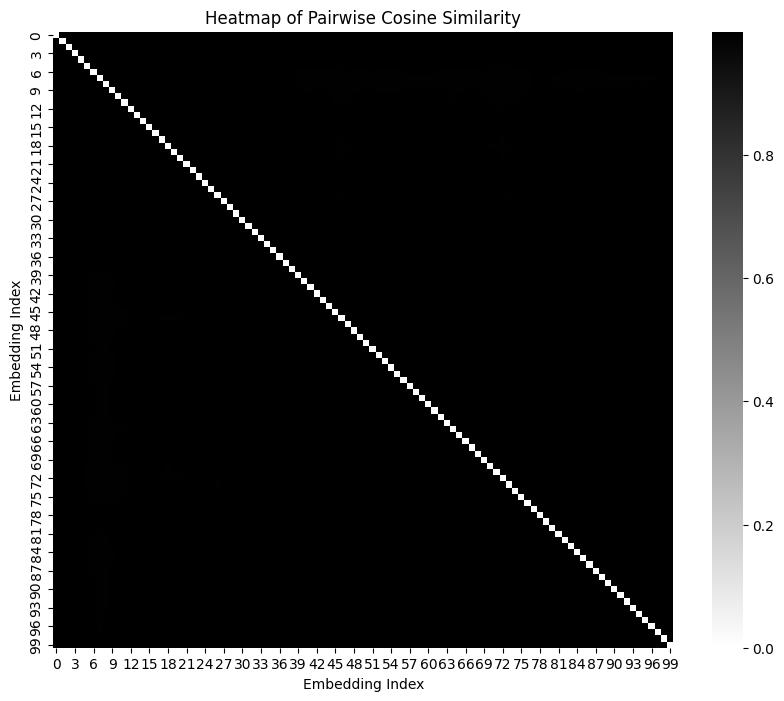

In [94]:
similarity_matrix_1, similar_pairs_1 = calculate_embeddings_similarity(ts_embedding_1)
plot_similarity_heatmap(similarity_matrix_1)

In [95]:
sorted_matrix_1, sorted_pairs_1 = sort_similarity_matrix(similarity_matrix_1)

Pairwise cosine similarity (sorted):
 [[0.99999965 0.99999965 0.99999951 ... 0.99999274 0.99999261 0.99999261]
 [0.99999257 0.99999257 0.99999237 ... 0.99998698 0.99998695 0.99998695]
 [0.99998684 0.99998684 0.9999868  ... 0.99998044 0.9999803  0.9999803 ]
 ...
 [0.99523868 0.99523868 0.99523189 ... 0.99440868 0.99440553 0.99440553]
 [0.99439952 0.99439952 0.99439833 ... 0.99240792 0.99204932 0.99204932]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(91, 92, 0.9999996524588202), (87, 88, 0.9999995130551899), (19, 20, 0.9999994236217397), (96, 97, 0.9999992351143745), (60, 61, 0.9999991951322397), (90, 93, 0.9999984811487154), (53, 54, 0.9999983512826219), (52, 53, 0.9999978979254002), (94, 96, 0.9999978777204482), (94, 95, 0.9999978063373247), (32, 33, 0.9999977232172086), (22, 23, 0.9999976568417903), (84, 85, 0.9999976557836966), (70, 71, 0.9999976333399476), (95, 96, 0.9999976139709433), (33, 34, 0.9999975548135827), (59, 60, 0.99999720526

<a id = 'example_1_heatmap'></a>

#### Example 2: Segment 2 from Amazon data

In [96]:
data_2 = normalize_data(segment_2,'Close')
ts_embedding_2 = create_and_train_ts_embedding (data_2)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0777Epoch 1, Loss: 0.06970086693763733
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0745
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0340Epoch 2, Loss: 0.02859457954764366
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0329
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0100Epoch 3, Loss: 0.00903430674225092
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0096
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0109Epoch 4, Loss: 0.011185024864971638
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0093Epoch 5, Loss: 0.008896268904209137
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0091
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064Epoch 6, Loss: 0.006427092477679253
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062Epoch 7, Loss: 0.006481710821390152
4/4

In [97]:
embeddings_2 = print_ts_embeddings_info (ts_embedding_2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 8.77129734e-02 -2.82218754e-02 -9.08234268e-02 -6.33240193e-02
   8.98380056e-02  7.36910105e-02 -5.23185171e-03  1.83516480e-02
  -7.41935745e-02  1.76684782e-01 -8.09642673e-02  8.11401289e-03
  -2.37127319e-02 -2.41681319e-02 -9.73116755e-02 -9.60303769e-02
  -2.88307779e-02  5.71070462e-02  1.33836806e-01 -5.76189011e-02
  -1.57635376e-01 -9.73210577e-03  1.61005154e-01  1.01079717e-01
   2.60022208e-02 -1.38236761e-01 -1.17413662e-01 -3.56818810e-02
   9.84521657e-02  1.80407509e-01  5.70712090e-02 -1.01952195e-01
   3.62917632e-02 -1.04745470e-01  7.97979385e-02 -5.45703098e-02
  -8.68841633e-02 -1.30107671e-01 -4.41309670e-03 -5.24529181e-02
  -1.45915195e-01  2.65558183e-01  1.58660151e-02 -1.25484854e-01
  -5.00083044e-02  7.69692734e-02 -1.43618435e-01  1.48244232e-01
   1.03835665e-01  7.84219429e-02]
 [ 8.44211727e-02 -2.91624349e-02 -8.52079690e-02 -6.14038631e-02
   8.67642388e-02 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Pairwise cosine similarity:
 [[0.         0.99973845 0.99914505 ... 0.99429137 0.99574444 0.99631635]
 [0.99973845 0.         0.99981838 ... 0.99341458 0.99519535 0.9961288 ]
 [0.99914505 0.99981838 0.         ... 0.9928142  0.99474737 0.99588143]
 ...
 [0.99429137 0.99341458 0.9928142  ... 0.         0.99963171 0.99869119]
 [0.99574444 0.99519535 0.99474737 ... 0.99963171 0.         0.99970683]
 [0.99631635 0.9961288  0.99588143 ... 0.99869119 0.99970683 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9997384460908243), (0, 2, 0.9991450500607362), (0, 3, 0.9983871828095812), (0, 4, 0.9976438792091652), (0, 5, 0.9968677494982902), (0, 6, 0.9962305584749912), (0, 7, 0.995752731535647), (0, 8, 0.9954561468076137), (0, 9, 0.9949719019166314), (0, 10, 0.9936144831116862), (0, 11, 0.9921512049260546), (0, 12, 0.9915214471960441), (0, 13, 0.9906468770372049), (0, 14, 0.9896539549760756), (0, 15, 0.9891229412781679), (0, 16, 0.9889366989927495), 

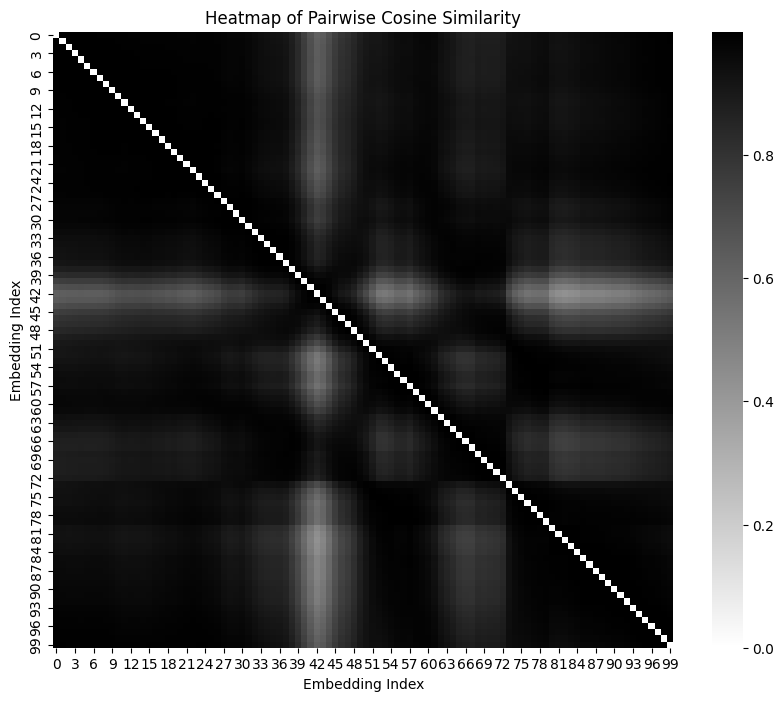

In [98]:
similarity_matrix_2, similar_pairs_2 = calculate_embeddings_similarity(ts_embedding_2)
plot_similarity_heatmap(similarity_matrix_2)

In [99]:
sorted_matrix_2, sorted_pairs_2 = sort_similarity_matrix(similarity_matrix_2)

Pairwise cosine similarity (sorted):
 [[0.99996323 0.99996323 0.99996195 ... 0.99971243 0.99970683 0.99970683]
 [0.99970326 0.99970326 0.99970218 ... 0.99929124 0.99928088 0.99928088]
 [0.99926864 0.99926864 0.99925152 ... 0.99881458 0.99878183 0.99878183]
 ...
 [0.62297588 0.62297588 0.62281747 ... 0.57223904 0.57172039 0.57172039]
 [0.57120715 0.57120715 0.56971038 ... 0.44263624 0.43277248 0.43277248]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(12, 13, 0.9999632269267732), (6, 7, 0.999961949728434), (90, 91, 0.9999554128851591), (13, 14, 0.9999549550224933), (87, 88, 0.9999546895457198), (5, 6, 0.9999431720422693), (16, 17, 0.9999355955368188), (21, 22, 0.9999348163151447), (7, 8, 0.9999302423216174), (18, 19, 0.9999215617454967), (14, 15, 0.9999196050058465), (86, 87, 0.9999161354552463), (3, 4, 0.9999092615075947), (91, 92, 0.9999090232902558), (4, 5, 0.9999075706297024), (10, 11, 0.9998974138616198), (85, 86, 0.9998833629116998), (20

#### Example 3: Segment 3 from Amazon data

In [100]:
data_3 = normalize_data(segment_3,'Close')
ts_embedding_3 = create_and_train_ts_embedding (data_3)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2477Epoch 1, Loss: 0.2254270613193512
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2388
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0942Epoch 2, Loss: 0.08337919414043427
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0920
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0155Epoch 3, Loss: 0.012889363802969456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0150
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0213Epoch 4, Loss: 0.02457866445183754
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0226
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0190Epoch 5, Loss: 0.015824787318706512
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0177
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0064Epoch 6, Loss: 0.0066426657140254974
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0065
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0097Epoch 7, Loss: 0.00893406756222248
4/4 

In [101]:
embeddings_3 = print_ts_embeddings_info (ts_embedding_3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.04508991 -0.08211956  0.16966662  0.07779615 -0.08042534 -0.11752456
  -0.1058201   0.07484125 -0.04345564  0.03737634  0.01821295 -0.04379515
  -0.06813622  0.09410837  0.03300136 -0.00226265 -0.00243607 -0.09748556
   0.0575888   0.02256278 -0.00276872 -0.15859435  0.03191219  0.03699777
   0.04220092  0.08095402 -0.07766246  0.06606555  0.00407493  0.11433337
  -0.02001528 -0.06426105 -0.07063702  0.102206    0.05074845 -0.10189148
  -0.07922348  0.04266269 -0.10247494 -0.05774206 -0.02977268 -0.02976366
  -0.12071788  0.00556658  0.01755437 -0.02397675  0.02171797  0.05449849
  -0.02622048 -0.04939379]
 [ 0.04880016 -0.08667287  0.17595911  0.07902656 -0.08441602 -0.12308327
  -0.11082644  0.0775647  -0.04738999  0.03918538  0.01961475 -0.04736679
  -0.07199614  0.09892899  0.03557181 -0.00219583 -0.0017629  -0.10133708
   0.05891246  0.02185285 -0.00179153 -0.16329381  0.03454983  0.03936

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Pairwise cosine similarity:
 [[0.         0.99987714 0.99970065 ... 0.99889688 0.99897287 0.99872467]
 [0.99987714 0.         0.99995779 ... 0.99813391 0.99822829 0.99790025]
 [0.99970065 0.99995779 0.         ... 0.99767307 0.99777286 0.9974076 ]
 ...
 [0.99889688 0.99813391 0.99767307 ... 0.         0.99999191 0.99997774]
 [0.99897287 0.99822829 0.99777286 ... 0.99999191 0.         0.99998311]
 [0.99872467 0.99790025 0.9974076  ... 0.99997774 0.99998311 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9998771447699387), (0, 2, 0.9997006534001083), (0, 3, 0.9994959574169152), (0, 4, 0.9995028221928973), (0, 5, 0.9994070666913385), (0, 6, 0.9991329829342432), (0, 7, 0.9991434520253074), (0, 8, 0.9992036520535574), (0, 9, 0.9992064847018418), (0, 10, 0.999220116043077), (0, 11, 0.9991917169019691), (0, 12, 0.9991844234325055), (0, 13, 0.9991353131799319), (0, 14, 0.9990271165276936), (0, 15, 0.9988291119045645), (0, 16, 0.9991328829137497), 

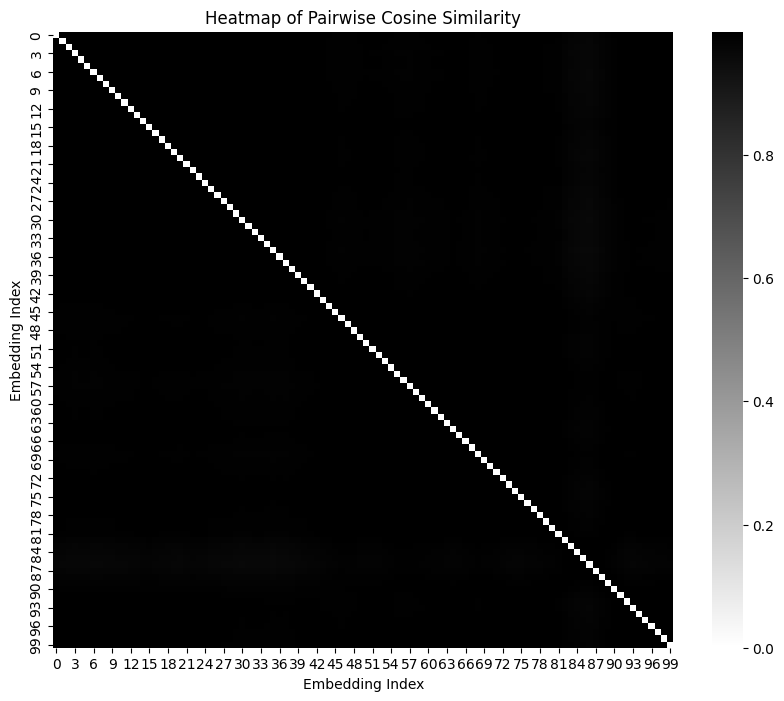

In [102]:
similarity_matrix_3, similar_pairs_3 = calculate_embeddings_similarity(ts_embedding_3)
plot_similarity_heatmap(similarity_matrix_3)

In [103]:
sorted_matrix_3, sorted_pairs_3 = sort_similarity_matrix(similarity_matrix_3)

Pairwise cosine similarity (sorted):
 [[0.99999859 0.99999859 0.99999777 ... 0.9999758  0.9999753  0.9999753 ]
 [0.99997393 0.99997393 0.99997326 ... 0.99995251 0.9999525  0.9999525 ]
 [0.99995231 0.99995231 0.99995201 ... 0.99992465 0.99992448 0.99992448]
 ...
 [0.97820576 0.97820576 0.97810313 ... 0.97480355 0.97472871 0.97472871]
 [0.97472514 0.97472514 0.97467917 ... 0.96825222 0.96716662 0.96716662]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(23, 24, 0.9999985915291302), (19, 20, 0.9999977661498892), (32, 33, 0.9999974190388372), (51, 52, 0.999997364173264), (27, 28, 0.9999961897399829), (10, 11, 0.9999958181905202), (74, 75, 0.9999940354422158), (36, 37, 0.9999928134923581), (97, 98, 0.9999919110325), (4, 5, 0.9999910314962964), (34, 36, 0.9999906770504469), (56, 57, 0.9999901847324175), (33, 34, 0.999990027274025), (34, 37, 0.9999899567692293), (79, 80, 0.9999889873712525), (73, 74, 0.9999880702505045), (58, 59, 0.9999878345163234),

#### Example 4: Segment 4 from Amazon data

In [104]:
data_4 = normalize_data(segment_4,'Close')
ts_embedding_4 = create_and_train_ts_embedding (data_4)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3213Epoch 1, Loss: 0.289244145154953
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3085
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1528Epoch 2, Loss: 0.15316569805145264
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1529
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0756Epoch 3, Loss: 0.06692273914813995
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0721
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0249Epoch 4, Loss: 0.022480564191937447
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0240
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0270Epoch 5, Loss: 0.02975348010659218
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0281
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0275Epoch 6, Loss: 0.02704634889960289
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0274
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0160Epoch 7, Loss: 0.01583314687013626
4/4 ━━━━

In [105]:
embeddings_4 = print_ts_embeddings_info (ts_embedding_4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.00038457  0.05555335 -0.04362847 -0.04143515 -0.02020844  0.0149433
   0.00668531  0.06795573 -0.0221638  -0.0304567  -0.01852767  0.0426343
   0.01662464  0.01898702  0.03607815 -0.01829444 -0.01054121  0.05198483
   0.02096199  0.0141047   0.03832132  0.01047595  0.04662002  0.01266501
  -0.04776149  0.02682028 -0.07365008  0.02116597  0.01566195  0.00591783
   0.02833961 -0.02603816  0.01594136  0.0005433   0.0173835  -0.00210007
   0.00330125  0.02144757  0.03602802 -0.06518569 -0.02394046  0.02845371
   0.04208007 -0.00908324  0.03091473 -0.01395025 -0.03804313 -0.00080601
  -0.00993164 -0.02577768]
 [ 0.00164461  0.05155226 -0.04284652 -0.03778455 -0.02221803  0.01140389
   0.00581282  0.06150442 -0.02324003 -0.02615489 -0.01880425  0.03824973
   0.01433522  0.01646016  0.03513149 -0.01496173 -0.01005169  0.04715535
   0.01941847  0.01200518  0.03562476  0.01241009  0.04764881  0.0150010

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Pairwise cosine similarity:
 [[0.         0.99785692 0.99590536 ... 0.92952199 0.93038652 0.93408939]
 [0.99785692 0.         0.99954199 ... 0.90483634 0.90583221 0.91021713]
 [0.99590536 0.99954199 0.         ... 0.89550959 0.89636884 0.90077165]
 ...
 [0.92952199 0.90483634 0.89550959 ... 0.         0.9999463  0.99968631]
 [0.93038652 0.90583221 0.89636884 ... 0.9999463  0.         0.99987334]
 [0.93408939 0.91021713 0.90077165 ... 0.99968631 0.99987334 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9978569192027765), (0, 2, 0.9959053626038504), (0, 3, 0.989798070395319), (0, 4, 0.984215486227706), (0, 5, 0.9787862594652555), (0, 6, 0.9723389159185076), (0, 7, 0.946526978711969), (0, 8, 0.9267859446958799), (0, 9, 0.9035081618457634), (0, 11, 0.9012391590186387), (0, 12, 0.9108376860232309), (0, 13, 0.9100566819285125), (0, 14, 0.9264483514674631), (0, 15, 0.9438636805176867), (0, 16, 0.953616275986315), (0, 17, 0.9608950449137527), (0,

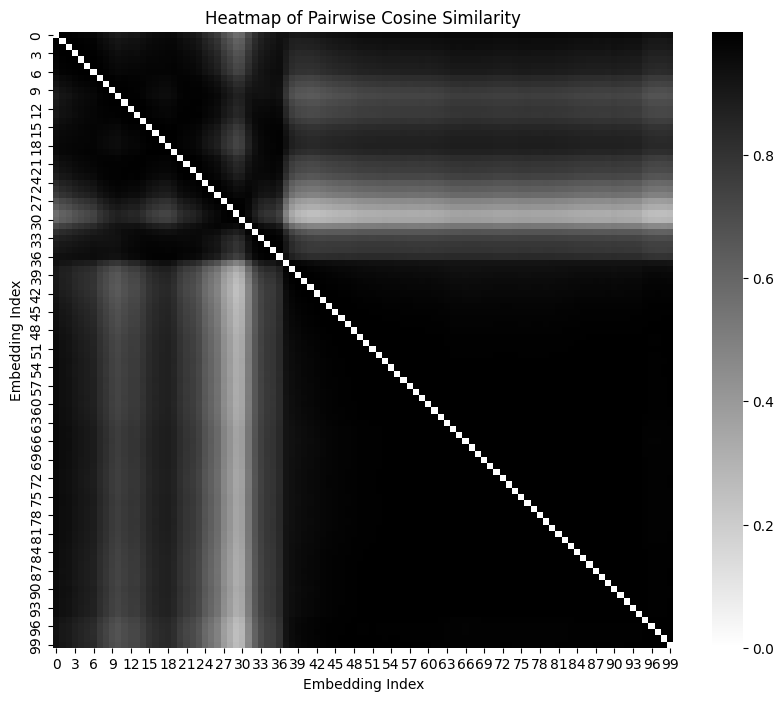

In [106]:
similarity_matrix_4, similar_pairs_4 = calculate_embeddings_similarity(ts_embedding_4)
plot_similarity_heatmap(similarity_matrix_4)

In [107]:
sorted_matrix_4, sorted_pairs_4 = sort_similarity_matrix(similarity_matrix_4)

Pairwise cosine similarity (sorted):
 [[0.99999954 0.99999954 0.99999908 ... 0.99997632 0.99997591 0.99997591]
 [0.99997548 0.99997548 0.9999754  ... 0.99995533 0.99995526 0.99995526]
 [0.99995385 0.99995385 0.99995348 ... 0.99991553 0.99991426 0.99991426]
 ...
 [0.35493105 0.35493105 0.35400135 ... 0.32870287 0.32798322 0.32798322]
 [0.3276036  0.3276036  0.32751003 ... 0.25305747 0.25293288 0.25293288]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(78, 80, 0.9999995356744676), (77, 78, 0.9999990753633831), (72, 73, 0.9999986367749519), (75, 76, 0.9999984023692065), (93, 94, 0.9999983342655158), (77, 80, 0.9999977978421223), (78, 79, 0.9999973822760196), (79, 80, 0.9999973159820026), (92, 93, 0.9999971362866117), (81, 82, 0.9999970925326749), (77, 79, 0.999997092014492), (88, 89, 0.9999962143720451), (71, 72, 0.9999961728194756), (69, 70, 0.9999956975956538), (87, 88, 0.9999951634603638), (74, 78, 0.9999949652600538), (85, 86, 0.999994146902

#### Example 5: Segment 5 from Amazon data

In [108]:
data_5 = normalize_data(segment_5,'Close')
ts_embedding_5 = create_and_train_ts_embedding (data_5)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3189Epoch 1, Loss: 0.3026023209095001
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3124
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1712Epoch 2, Loss: 0.1564582735300064
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1653
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0756Epoch 3, Loss: 0.05625767633318901
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0679
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0099Epoch 4, Loss: 0.011125284247100353
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0104
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0269Epoch 5, Loss: 0.02531450055539608
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0263
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0122Epoch 6, Loss: 0.011411148123443127
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0119
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0075Epoch 7, Loss: 0.008509811013936996
4/4 ━━

In [109]:
embeddings_5 = print_ts_embeddings_info (ts_embedding_5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.0322193  -0.02374928  0.01449651  0.0114956   0.0219664  -0.00194503
   0.02298054  0.06241062  0.03539634 -0.01531708  0.00539041 -0.01410634
   0.00842829  0.01692162  0.01978855  0.02066613  0.04374483  0.02737182
   0.01566095  0.01090345 -0.0387412  -0.00691014 -0.03386489  0.00268372
  -0.04321451 -0.02759129 -0.06444476 -0.02973589 -0.02848408  0.02494894
   0.00490555  0.02591502 -0.02341117  0.02428276  0.01654613  0.02259684
   0.00100643 -0.01546564 -0.01666172 -0.02877068 -0.0269265  -0.00267108
   0.01663953  0.03204678 -0.02678402 -0.04773292 -0.05248949 -0.04173855
  -0.02995498  0.01988199]
 [-0.02930737 -0.02544171  0.01516381  0.00829028  0.02211341 -0.00068753
   0.02287939  0.0573772   0.03584073 -0.01537124  0.00375233 -0.01280809
   0.00658929  0.0161312   0.01701921  0.01840233  0.04102502  0.02720106
   0.01413872  0.01319169 -0.03813405 -0.00833725 -0.03498515  0.00539

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Pairwise cosine similarity:
 [[0.         0.99773368 0.99708758 ... 0.89941598 0.89996329 0.9018317 ]
 [0.99773368 0.         0.99980671 ... 0.87020215 0.8708122  0.87295964]
 [0.99708758 0.99980671 0.         ... 0.86445433 0.86509904 0.86726792]
 ...
 [0.89941598 0.87020215 0.86445433 ... 0.         0.99999515 0.99997268]
 [0.89996329 0.8708122  0.86509904 ... 0.99999515 0.         0.99998531]
 [0.9018317  0.87295964 0.86726792 ... 0.99997268 0.99998531 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9977336766478712), (0, 2, 0.9970875772587924), (0, 3, 0.9926473667591815), (0, 4, 0.9691879588564278), (0, 5, 0.9572468958484959), (0, 6, 0.9206588307492124), (0, 7, 0.9172685359517351), (0, 8, 0.9217510133371292), (0, 9, 0.9397305570746438), (0, 10, 0.9467422683310497), (0, 11, 0.9628188370043216), (0, 12, 0.9770212088716744), (0, 13, 0.982145359902029), (0, 14, 0.9874633628644416), (0, 15, 0.9900405539696594), (0, 16, 0.9907506612464287), 

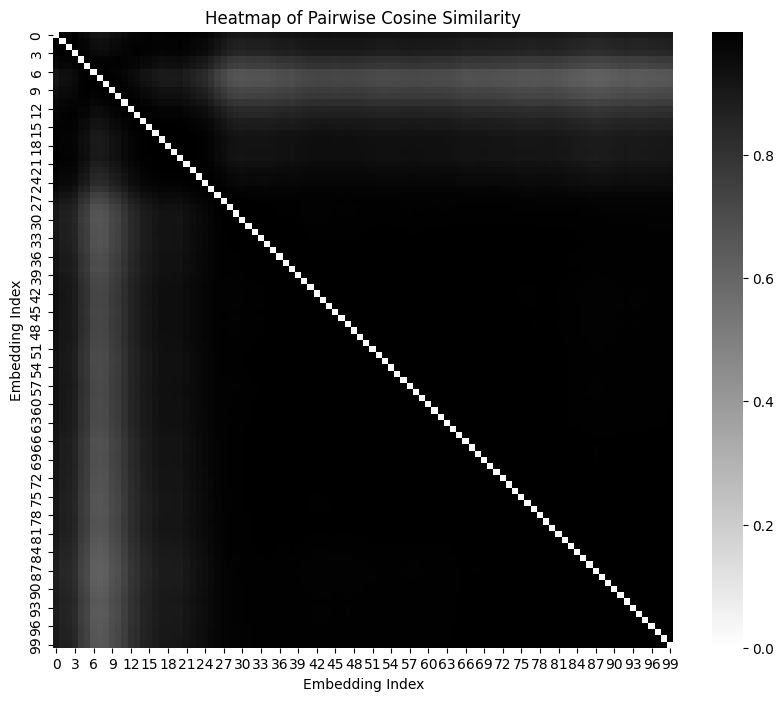

In [110]:
similarity_matrix_5, similar_pairs_5 = calculate_embeddings_similarity(ts_embedding_5)
plot_similarity_heatmap(similarity_matrix_5)

In [111]:
sorted_matrix_5, sorted_pairs_5 = sort_similarity_matrix(similarity_matrix_5)

Pairwise cosine similarity (sorted):
 [[0.99999849 0.99999849 0.99999782 ... 0.9999819  0.99998187 0.99998187]
 [0.99998008 0.99998008 0.99997929 ... 0.9999569  0.9999569  0.9999569 ]
 [0.99995594 0.99995594 0.99995576 ... 0.99992902 0.9999281  0.9999281 ]
 ...
 [0.68131466 0.68131466 0.68084295 ... 0.66412144 0.66356496 0.66356496]
 [0.66259549 0.66259549 0.66207212 ... 0.62412176 0.62110605 0.62110605]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(61, 62, 0.9999984860794151), (61, 63, 0.9999978162932873), (62, 63, 0.9999976724323649), (46, 47, 0.9999975717032208), (60, 62, 0.9999964963281057), (68, 69, 0.999996237440162), (47, 48, 0.9999958855788943), (57, 58, 0.9999958684615631), (60, 61, 0.9999957558826135), (76, 77, 0.9999956910514417), (97, 98, 0.9999951460378443), (93, 94, 0.9999949116538066), (75, 76, 0.999994570210301), (46, 48, 0.9999941978300135), (59, 60, 0.9999935218061493), (79, 80, 0.9999931452357848), (71, 72, 0.9999930483539

#### Example 6: Segment 6 from Amazon data

In [112]:
data_6 = normalize_data(segment_6,'Close')
ts_embedding_6 = create_and_train_ts_embedding (data_6)

200
Epoch 1/20


c:\Users\Žan Grčar\python\ts2g2\tutorials\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1114Epoch 1, Loss: 0.09422803670167923
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1045
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0225Epoch 2, Loss: 0.02042466215789318
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0221
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0244Epoch 3, Loss: 0.02594754286110401
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0250
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0123Epoch 4, Loss: 0.014244050718843937
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0131
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0122Epoch 5, Loss: 0.011899381875991821
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0121
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0162Epoch 6, Loss: 0.013615718111395836
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0157
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0135Epoch 7, Loss: 0.01275620236992836
4/4 

In [113]:
embeddings_6 = print_ts_embeddings_info (ts_embedding_6)
print(embeddings_6.size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.01014009  0.10549383 -0.05549335  0.02752589  0.05164953  0.01193386
  -0.06537531  0.00670151 -0.02902121  0.01351234  0.02929645  0.08092832
  -0.01453768 -0.10797849  0.00430156 -0.0432998   0.03987426  0.00617919
   0.1078535   0.02632707 -0.12902555 -0.02288718 -0.0173671   0.06825851
  -0.0878555   0.01881495 -0.02669577  0.05790548  0.0245363   0.05690876
   0.02196999  0.03652666 -0.08036683  0.07176143 -0.01624762  0.02182583
  -0.04891239 -0.02223173  0.11244177 -0.01294322  0.05702789 -0.00306258
   0.01844296 -0.06820937 -0.13218474 -0.07488878  0.05429699 -0.01921785
  -0.09772937  0.00790231]
 [ 0.00863343  0.1000508  -0.0529842   0.02674636  0.04926767  0.01152928
  -0.06272792  0.00612412 -0.02665178  0.01410286  0.02715917  0.07572407
  -0.01449296 -0.10255075  0.00523007 -0.04118815  0.03701944  0.00610523
   0.10321812  0.02427751 -0.12169059 -0.02259733 -0.0169425   0.06435

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Pairwise cosine similarity:
 [[0.         0.99991385 0.99985154 ... 0.98929207 0.98994103 0.99087498]
 [0.99991385 0.         0.99995508 ... 0.98779886 0.98850854 0.98952666]
 [0.99985154 0.99995508 0.         ... 0.98840967 0.98908793 0.99006662]
 ...
 [0.98929207 0.98779886 0.98840967 ... 0.         0.99997366 0.99987255]
 [0.98994103 0.98850854 0.98908793 ... 0.99997366 0.         0.99996066]
 [0.99087498 0.98952666 0.99006662 ... 0.99987255 0.99996066 0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9999138450791122), (0, 2, 0.999851539663064), (0, 3, 0.999716609010073), (0, 4, 0.9994819928332528), (0, 5, 0.9992343262589753), (0, 6, 0.9977242632811222), (0, 7, 0.9949919678244732), (0, 8, 0.9935162773213463), (0, 9, 0.996561041684609), (0, 10, 0.9966699024420745), (0, 11, 0.9940974995614006), (0, 12, 0.9900961036996571), (0, 13, 0.9839175815859799), (0, 14, 0.9723654905473134), (0, 15, 0.9601622293844041), (0, 16, 0.9538142749420434), (0

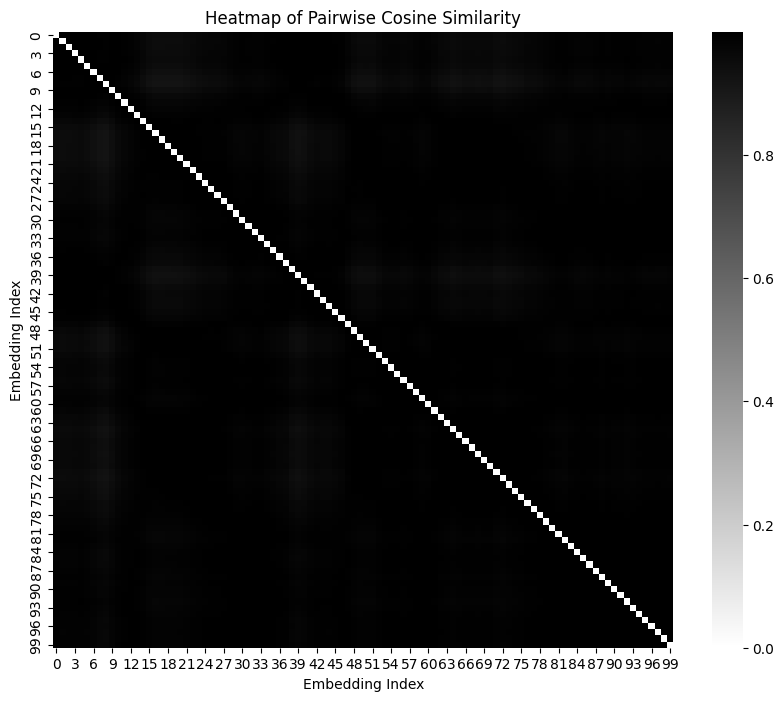

In [114]:
similarity_matrix_6, similar_pairs_6 = calculate_embeddings_similarity(ts_embedding_6)
plot_similarity_heatmap(similarity_matrix_6)

In [115]:
sorted_matrix_6, sorted_pairs_6 = sort_similarity_matrix(similarity_matrix_6)

Pairwise cosine similarity (sorted):
 [[0.99999494 0.99999494 0.99999188 ... 0.99991188 0.99990886 0.99990886]
 [0.99990295 0.99990295 0.99990259 ... 0.9998173  0.99981713 0.99981713]
 [0.99981638 0.99981638 0.99981389 ... 0.9997285  0.99972775 0.99972775]
 ...
 [0.94927773 0.94927773 0.94927609 ... 0.94247024 0.94234784 0.94234784]
 [0.94204465 0.94204465 0.94202817 ... 0.92380451 0.92365258 0.92365258]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Sorted pairs:
 [(90, 91, 0.9999949388543314), (69, 70, 0.9999918812084794), (68, 69, 0.9999915440362046), (95, 96, 0.9999903810534272), (66, 67, 0.9999886860092083), (67, 68, 0.9999876596275801), (25, 26, 0.999981576241342), (32, 33, 0.9999813507722916), (67, 69, 0.9999800533551879), (96, 98, 0.9999781561862889), (54, 55, 0.9999748138632505), (43, 44, 0.999974144679683), (97, 98, 0.9999736622228881), (84, 85, 0.9999704753742296), (19, 20, 0.9999691543911067), (68, 70, 0.99996750085331), (96, 97, 0.999962997995667

Based on above presented heatmaps we can conclude that all of them have a white diagonal that represents zeros for the same valued pairs. Out of the six examples [Example 1: Segment 1 from Amazon data](#example-1-segment-1-from-amazon-data) and [Example 3: Segment 3 from Amazon data](#example-3-segment-3-from-amazon-data) are the most similar by their embeddings. If we compare their time series graphs we can also see that the graphs are quite similar, both of them contain increasing values. 